In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *


# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

# Set up

In [2]:
# Import helpful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import linear_model
from xgboost import XGBRegressor




train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
y = train_data.pop("SalePrice")



# Mutual infomation: 
to help delete useless info that not help with our prediction

In [3]:
# get mutual information scores
def mi_scores(X, y,discrete):
    if(discrete):
        mi_scores = mutual_info_regression(X, y, random_state=0,discrete_features=X.dtypes==int)
    else:
        mi_scores=mutual_info_regression(X,y,random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# plot scores to get a visual diagram, better for comparation
def plot_mi_scores(scores,feature_type):
    scores=scores.sort_values(ascending=True)
    plt.barh(scores.index,scores)
    plt.title('Mutual Information Scores '+feature_type+ ' variables')
    

# separate columns between numeric and categoric
numerical=[col for col in train_data.columns if train_data[col].dtype!='object']
categorical=list(set(train_data.columns)-set(numerical))

# see what and how many data is missing
print("data shape(row, column):",train_data.shape)
print("data missing - missing count")
missing_val_count_by_column = (train_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])


no_miss_num=[col for col in numerical if train_data[col].isnull().sum()==0]
no_miss_cat=[col for col in categorical if train_data[col].isnull().sum()==0]
X=train_data[no_miss_cat].copy()
for col in no_miss_cat:
    X[col],_=X[col].factorize()
no_miss_cat=X.dtypes==int

# print(X.shape)




data shape(row, column): (1460, 80)
data missing - missing count
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [4]:
tempImputer = SimpleImputer(strategy = "most_frequent")
missing_cat=[col for col in categorical if train_data[col].isnull().sum()>0]
missing_num=[col for col in numerical if train_data[col].isnull().sum()>0]

X_miss = train_data[missing_cat].copy()
X_num_miss = train_data[missing_num].copy()
imputed_X_miss = pd.DataFrame(tempImputer.fit_transform(X_miss))
imputed_X_num = pd.DataFrame(tempImputer.fit_transform(X_num_miss))
imputed_X_miss.columns = X_miss.columns
imputed_X_num.columns = X_num_miss.columns

for col in missing_cat:
    imputed_X_miss[col],_=imputed_X_miss[col].factorize()
missing_cat=X.dtypes==int


**following code will print result table for mutual information**

* eg. ['Id','PoolArea', 'Condition2', 'Street' ,'MoSold','MiscVal','3SsnPorch','BsmtFinSF2','LandSlope','Utilities'] seems rather useless for this prediction according to the table

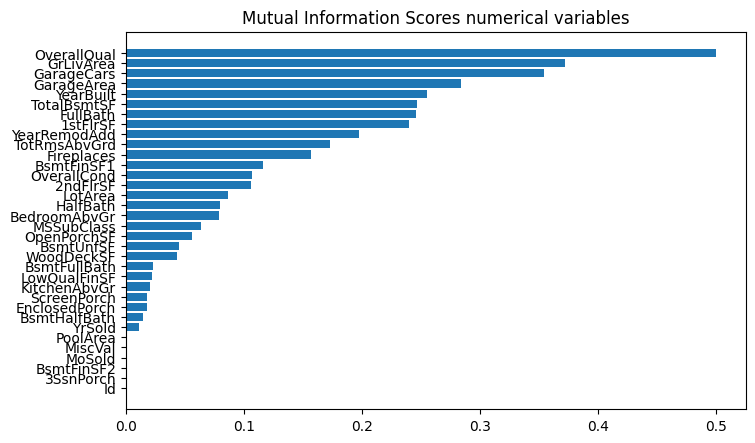

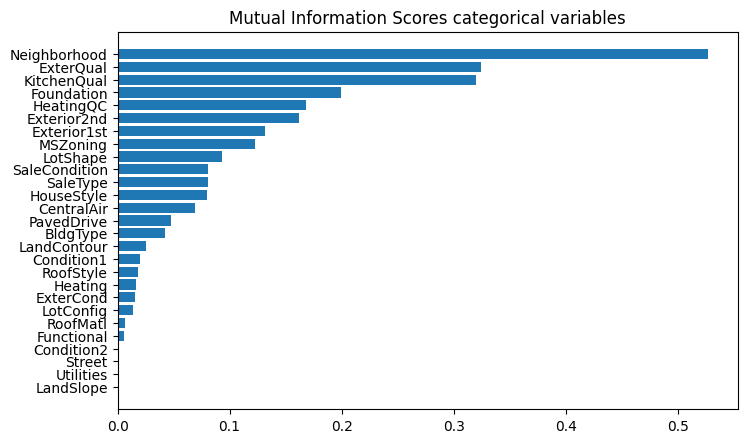

In [5]:
scores=mi_scores(train_data[no_miss_num],y,discrete=False)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(scores,'numerical')
plt.show()
plt.close()

plt.figure(dpi=100,figsize=(8,5))
scores=mi_scores(X,y,discrete=True)
plot_mi_scores(scores,'categorical')

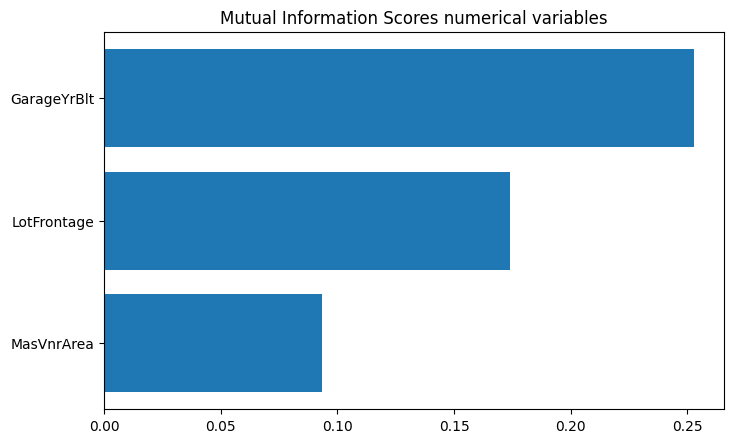

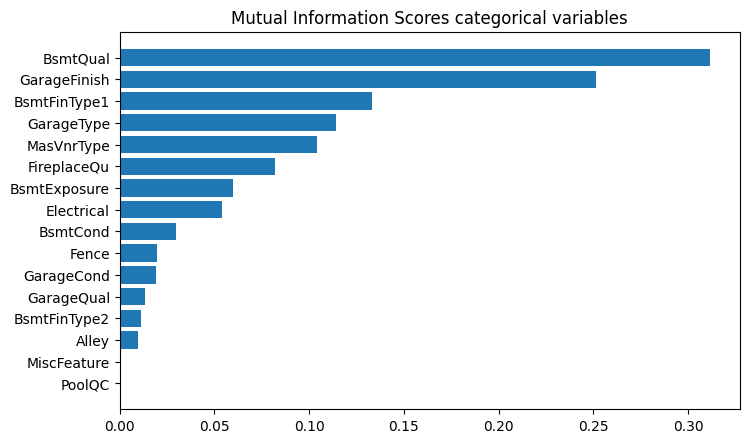

In [6]:
scores=mi_scores(imputed_X_num,y,discrete=False)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(scores,'numerical')
plt.show()
plt.close()

plt.figure(dpi=100,figsize=(8,5))
scores=mi_scores(imputed_X_miss,y,discrete=True)
plot_mi_scores(scores,'categorical')

# Set up cleaned data for training

In [7]:
numerical=[col for col in train_data.columns if train_data[col].dtype!='object']
categorical=list(set(train_data.columns)-set(numerical))

num_delete=['Id','PoolArea','MoSold','MiscVal','3SsnPorch','BsmtFinSF2',]
cat_delete=['LandSlope','Utilities','MiscFeature','Street']
[numerical.pop(numerical.index(feat)) for feat in num_delete]
[categorical.pop(categorical.index(feat)) for feat in cat_delete]

X_train=train_data[categorical+numerical]
X_test=test_data[categorical+numerical]

# Pipeline

In [8]:
numtr=SimpleImputer(strategy='median')
cattr=Pipeline(steps=[('Imputer',SimpleImputer(strategy='most_frequent')),('OHE',OneHotEncoder(handle_unknown='ignore',sparse=False))])
prepr=ColumnTransformer(transformers=[('num',numtr,numerical),('cat',cattr,categorical)])
#xgb=XGBRegressor(n_estimators=6000,learning_rate=0.01,random_state=0)
gb=GradientBoostingRegressor(n_estimators=6000,learning_rate=0.03,max_depth=2)
model=Pipeline(steps=[('preprocessor',prepr),('model',gb)])

# Grid Search

takes very long time

In [9]:

# numtr=SimpleImputer(strategy='median')
# cattr=Pipeline(steps=[('Imputer',SimpleImputer(strategy='most_frequent')),('OHE',OneHotEncoder(handle_unknown='ignore',sparse=False))])
# prepr=ColumnTransformer(transformers=[('num',numtr,numerical),('cat',cattr,categorical)])
# gb=GradientBoostingRegressor()
# model=Pipeline(steps=[('preprocessor',prepr),('model',gb)])
# param_grid = {'model__n_estimators': [5000,6000,7000,8000],'model__learning_rate': [0.01,0.02,0.03,0.04,0.05],
#     'model__max_depth':[1,2,3,4]}
# gridsearch=GridSearchCV(model,param_grid,n_jobs=4)
# gridsearch.fit(X_train,y)



# Train model

In [10]:
model.fit(X_train,y)
test_preds=model.predict(X_test)

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [11]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*